# `dask` Experiments for Elise's Plankton Averaging Workflow

This notebook explores the performance of `dask` and `xarray.open_mfdataset()` 
compared to looping over files with `netCDF4` for Elise's diatoms and microzooplankton
averaging workflow.

The packages required by this notebook are defined in the `conda` environment file `analysis-doug/notebooks/dask-expts/environment.yaml` along with instructions on how to created an isolated environment containing the latest versions of those packages.
The `analysis-doug/notebooks/dask-expts/requirements.txt` contains a complete list of all of the packages (top level and dependecies) and their versions that were used most recently for work in this notebook. 

To get some compute muscle,
I run this Jupyter Lab headless on port 9999 on `smelt` (similar architecture to Elise's `char` workstation) with:

  `jupyter lab --no-browser --port=9999`
   
and set up an `ssh` tunnel to connect to the kernel on port 9999 on `smelt` from my local machine's port 4343 with:

  `ssh -N -L 4343:localhost:9999 smelt`
  
and finally launch the lab UI in my local browser with:

  http://localhost:4343/

## `smelt`'s CPU and Memory

In [1]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                32
On-line CPU(s) list:   0-31
Thread(s) per core:    2
Core(s) per socket:    8
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 45
Model name:            Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz
Stepping:              7
CPU MHz:               1199.988
CPU max MHz:           3800.0000
CPU min MHz:           1200.0000
BogoMIPS:              5801.82
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              20480K
NUMA node0 CPU(s):     0-7,16-23
NUMA node1 CPU(s):     8-15,24-31
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopolog

In [2]:
!cat /proc/meminfo | head -1

MemTotal:       264118596 kB


4 physical cores with 2 threads per core of hyperthreading, so 8 logical cores, and 16Gb of RAM.

## Setup

Show `matplotlib` images inline,
and do Python imports.

In [1]:
%matplotlib inline

In [2]:
from datetime import datetime, timedelta
import functools
import sys
import time

import dask
import dask.distributed
import matplotlib.pyplot as plt
import netCDF4
import numpy
import xarray

from salishsea_tools import evaltools

Python and library versions:

In [3]:
print(f"Python {sys.version=}")
print(f"{xarray.__version__=}")
print(f"{dask.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{numpy.__version__=}")

Python sys.version='3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:38) \n[GCC 7.3.0]'
xarray.__version__='0.14.1'
dask.__version__='2.8.1'
netCDF4.__version__='1.5.3'
numpy.__version__='1.17.3'


## Timing Decorator

We can't use the `%%time` cell magic to time deferred `dask` operations
because all that shows us is the time it takes to add the deferred calculations
to the `dask` operations graph.
Instead we have to time explicitly with calls to `time.time()`,
and we use a function decorator to minimize the amount of boilerplate code for timing.
(For more details about functions within functions,
decorators,
and `functools.wraps()`,
please see https://realpython.com/primer-on-python-decorators/)

In [5]:
def function_timer(func):
    @functools.wraps(func)
    def wrapper_function_timer(*args, **kwargs):
        t_start = time.time()
        return_value = func(*args, **kwargs)
        t_end = time.time()
        print(f"{t_end - t_start}s")
        return return_value

    return wrapper_function_timer

## Grid Region of Interest

In [4]:
j0, j1, i0, i1 = 230, 470, 0, 200

## Looping Over Results Files Using `netCDF4`

### Meshmask Arrays Needed for Depth Averaging

In [7]:
with netCDF4.Dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    tmask=numpy.copy(mesh.variables['tmask'][:,:,j0:j1,i0:i1])
    e3t0=numpy.copy(mesh.variables['e3t_0'][:,:,j0:j1,i0:i1])

In [8]:
print(f"{tmask.shape=}")
print(f"{e3t0.shape=}")

tmask.shape=(1, 40, 240, 200)
e3t0.shape=(1, 40, 240, 200)


### Collection of file to Calculate Depth Averaged Quantities From

Operate on a single 10-day file because it is faster than
3 months of files while we are figuring out how to optimize
the code.

In [9]:
flistmuZ = evaltools.index_model_files(
    datetime(2015, 6, 1), datetime(2015, 6, 9),
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/",
    "long", 10, "ptrc_T", 1
)

first file starts on  2015-05-31 00:00:00


In [10]:
flistmuZ

,paths,t_0,t_n
0,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-31,2015-06-10


In [11]:
flistmuZ['t_0'][0], flistmuZ['t_n'][len(flistmuZ)-1]

(Timestamp('2015-05-31 00:00:00'), Timestamp('2015-06-10 00:00:00'))

In [12]:
@function_timer
def calc_depth_avgs(flist, tmask, e3t0):
    sum1 = numpy.empty((len(flist)*24*10, j1-j0, i1-i0))
    sum1uZ = numpy.empty((len(flist)*24*10, j1-j0, i1-i0))
    for ind, row in flist.iterrows():
        ds = netCDF4.Dataset(row['paths'])
        diatoms = ds.variables['diatoms'][:,:,j0:j1,i0:i1]
        uZ = ds.variables['microzooplankton'][:,:,j0:j1,i0:i1]
        sum1[(24*10*ind):(24*10*(ind+1)),:,:] = numpy.sum(tmask*e3t0*diatoms, 1)
        sum1uZ[(24*10*ind):(24*10*(ind+1)),:,:] = numpy.sum(tmask*e3t0*uZ, 1)
    diatom_int = numpy.mean(sum1, 0)
    microzoo_int = numpy.mean(sum1uZ, 0)
    return diatom_int, microzoo_int

In [13]:
diatoms_muZ_Int, uZ_muZ_Int = calc_depth_avgs(flistmuZ, tmask, e3t0)

504.31361055374146s


In [14]:
print(f"{diatoms_muZ_Int.shape=}")
print(f"{uZ_muZ_Int.shape=}")

diatoms_muZ_Int.shape=(240, 200)
uZ_muZ_Int.shape=(240, 200)


Re-write the depth average calculation for one file
without the loop and sum accumulator variables
as the first step towards using `xarray.open_mfdataset()`
and `dask.distributed`.

In [15]:
@function_timer
def calc_depth_avgs_no_loop(flist, tmask, e3t0):
    with netCDF4.Dataset(flist) as ds:
        diatoms = ds.variables['diatoms'][:,:,j0:j1,i0:i1]
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.variables['microzooplankton'][:,:,j0:j1,i0:i1]
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [16]:
diatoms_int, uZ_int = calc_depth_avgs_no_loop(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    tmask, e3t0)
numpy.testing.assert_equal(diatoms_int, diatoms_muZ_Int)
numpy.testing.assert_equal(uZ_int, uZ_muZ_Int)

593.3109464645386s


In [17]:
print(f"{diatoms_int.shape=}")
print(f"{uZ_int.shape=}")

diatoms_int.shape=(240, 200)
uZ_int.shape=(240, 200)


## Switch to `xarray`

Continue refactoring the depth average calculation for one file
to use `xarray.open_dataset()`.

In [18]:
with xarray.open_dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    x_tmask = mesh.tmask.isel(y=slice(j0, j1), x=slice(i0, i1)).data
    x_e3t0 = mesh.e3t_0.isel(y=slice(j0, j1), x=slice(i0, i1)).data

In [19]:
@function_timer
def calc_depth_avgs_xarray(flist, x_tmask, x_e3t0):
    with xarray.open_dataset(flist) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * x_tmask * x_e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * x_tmask * x_e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [20]:
x_diatoms_int, x_uZ_int = calc_depth_avgs_xarray(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    tmask, e3t0)
numpy.testing.assert_allclose(x_diatoms_int, diatoms_muZ_Int)
numpy.testing.assert_allclose(x_uZ_int, uZ_muZ_Int)

456.4098262786865s


In [21]:
print(f"{x_diatoms_int.shape=}")
print(f"{x_uZ_int.shape=}")

x_diatoms_int.shape=(240, 200)
x_uZ_int.shape=(240, 200)


## Use `dask.distributed`

Set up a local cluster of 2 workers with 2 threads per worker
with the workers launched as separate processes.
This will distribute the processing over multiple cores on `smelt`.

In [22]:
client = dask.distributed.Client(
    n_workers=2, threads_per_worker=2, processes=True)
client

Client Scheduler: tcp://127.0.0.1:43228 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 24 Memory: 270.46 GB


To make `xarray` use `dask` we have to pass a `chunks` dict to `open_dataset()`.

Because we are using `dask` this function does not return the results,
rather it returns the `dask` task graph that will be excuted to calculate the results.
So, there is no value in decorating it with `@function_timer`.
Instead, the assertions to confirm that the results are as expected are what triggers
the calculation, so, we move our assertions to into a `@function_timer` decorated function.

In [23]:
def calc_depth_avgs_dask(flist, chunks, tmask, e3t0):
    with xarray.open_dataset(flist, chunks=chunks) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [24]:
@function_timer
def check_results(diatoms_calc, diatoms_exp, uZ_calc, uZ_exp):
    numpy.testing.assert_allclose(diatoms_calc, diatoms_exp)
    numpy.testing.assert_allclose(uZ_calc, uZ_exp)

In [25]:
chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

27.72683548927307s


In [26]:
print(f"{x_diatoms_int.shape=}")
print(f"{x_uZ_int.shape=}")

x_diatoms_int.shape=(240, 200)
x_uZ_int.shape=(240, 200)


Increase the chunk size:

In [27]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

20.735081911087036s


Increase the number of workers:

In [32]:
client.cluster.scale(4)

In [33]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

20.83695673942566s


Increase the chunk size again:

In [34]:
chunks = {"time_counter": 4, "deptht": 40*4, "y": 898*4, "x": 398*4}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

26.398309469223022s


## Operating on More Than One File

## Looping with `netCDF4`

In [37]:
flistmuZ = evaltools.index_model_files(
    datetime(2015, 6, 1), datetime(2015, 6, 19),
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/",
    "long", 10, "ptrc_T", 1
)

first file starts on  2015-05-31 00:00:00


In [38]:
flistmuZ

,paths,t_0,t_n
0,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-31,2015-06-10
1,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-10,2015-06-20


In [39]:
flistmuZ['t_0'][0], flistmuZ['t_n'][len(flistmuZ)-1]

(Timestamp('2015-05-31 00:00:00'), Timestamp('2015-06-20 00:00:00'))

In [40]:
m_diatoms_muZ_Int, m_uZ_muZ_Int = calc_depth_avgs(flistmuZ, tmask, e3t0)

1086.6526288986206s


In [41]:
print(f"{diatoms_muZ_Int.shape=}")
print(f"{uZ_muZ_Int.shape=}")

diatoms_muZ_Int.shape=(240, 200)
uZ_muZ_Int.shape=(240, 200)


## `xarray.open_mfdataset()`

In [13]:
def calc_depth_avgs_mfdataset(flist, chunks, tmask, e3t0):
    kwargs = dict(combine="nested", concat_dim="time_counter", parallel=True)
    with xarray.open_mfdataset(flist, chunks=chunks, **kwargs) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [43]:
chunks = {"time_counter": 4, "deptht": 40*4, "y": 898*4, "x": 398*4}
mf_diatoms_int, mf_uZ_int = calc_depth_avgs_mfdataset(
    ["/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
     "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150610-20150619.nc",],
    chunks, tmask, e3t0)
check_results(mf_diatoms_int, m_diatoms_muZ_Int, mf_uZ_int, m_uZ_muZ_Int)

35.82601809501648s


In [44]:
client.close()

## The Whole Enchillada

`dask.distributed` and `xarray.open_mfdataset()` implementation of the
~3 month averaging and visualization in `tryDask-nc.ipynb`.
This section was run on `salish` to take advantage of more cores and memory.

In [5]:
with xarray.open_dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    x_tmask = mesh.tmask.isel(y=slice(j0, j1), x=slice(i0, i1)).data
    x_e3t0 = mesh.e3t_0.isel(y=slice(j0, j1), x=slice(i0, i1)).data

In [6]:
flistmuZ = evaltools.index_model_files(
    datetime(2015, 6, 1), datetime(2015, 9, 1),
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/",
    "long", 10, "ptrc_T", 1
)

first file starts on  2015-05-31 00:00:00


In [7]:
flistmuZ

,paths,t_0,t_n
0,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-31,2015-06-10
1,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-10,2015-06-20
2,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-20,2015-06-30
3,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-30,2015-07-10
4,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-10,2015-07-20
5,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-20,2015-07-30
6,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-30,2015-08-09
7,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-09,2015-08-19
8,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-19,2015-08-29
9,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-29,2015-09-08


In [8]:
flistmuZ['t_0'][0], flistmuZ['t_n'][len(flistmuZ)-1]

(Timestamp('2015-05-31 00:00:00'), Timestamp('2015-09-08 00:00:00'))

In [9]:
flistHC = evaltools.index_model_files(
    flistmuZ['t_0'][0], flistmuZ['t_n'][len(flistmuZ)-1] - timedelta(days=1),
    '/results/SalishSea/hindcast.201905/', 'nowcast', 1, 'ptrc_T', 1)

In [10]:
flistHC

,paths,t_0,t_n
0,/results/SalishSea/hindcast.201905/31may15/Sal...,2015-05-31,2015-06-01
1,/results/SalishSea/hindcast.201905/01jun15/Sal...,2015-06-01,2015-06-02
2,/results/SalishSea/hindcast.201905/02jun15/Sal...,2015-06-02,2015-06-03
3,/results/SalishSea/hindcast.201905/03jun15/Sal...,2015-06-03,2015-06-04
4,/results/SalishSea/hindcast.201905/04jun15/Sal...,2015-06-04,2015-06-05
...,...,...,...
95,/results/SalishSea/hindcast.201905/03sep15/Sal...,2015-09-03,2015-09-04
96,/results/SalishSea/hindcast.201905/04sep15/Sal...,2015-09-04,2015-09-05
97,/results/SalishSea/hindcast.201905/05sep15/Sal...,2015-09-05,2015-09-06
98,/results/SalishSea/hindcast.201905/06sep15/Sal...,2015-09-06,2015-09-07


In [11]:
def calc_depth_avgs_mfdataset(flist, chunks, tmask, e3t0):
    kwargs = dict(combine="nested", concat_dim="time_counter", parallel=True)
    with xarray.open_mfdataset(flist, chunks=chunks, **kwargs) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [12]:
client = dask.distributed.Client(
    n_workers=12, threads_per_worker=2, processes=True)
client

Client Scheduler: tcp://127.0.0.1:44061 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 24 Memory: 270.46 GB


In [13]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}

In [14]:
x_diatoms_muZ_int, x_uZ_muZ_int = calc_depth_avgs_mfdataset(
    [row["paths"] for _, row in flistmuZ.iterrows()], chunks, x_tmask, x_e3t0
)

In [15]:
x_diatomsHC_int, x_uZHC_int = calc_depth_avgs_mfdataset(
    [row["paths"] for _, row in flistHC.iterrows()], chunks, x_tmask, x_e3t0
)

In [16]:
%%time
diatomsmuZInt = x_diatoms_muZ_int.compute()

CPU times: user 28.1 s, sys: 2.84 s, total: 31 s
Wall time: 3min 42s


In [17]:
%%time
diatomsHCInt = x_diatomsHC_int.compute()

CPU times: user 26.9 s, sys: 2.35 s, total: 29.2 s
Wall time: 3min 23s


Text(0.5, 1.0, 'Diff')

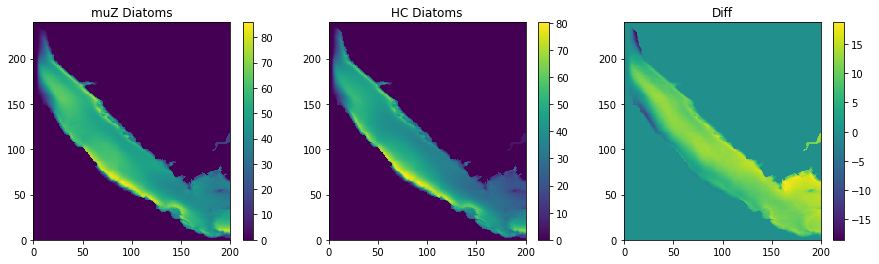

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
m0 = ax[0].pcolormesh(diatomsmuZInt)
plt.colorbar(m0, ax=ax[0])
ax[0].set_title('muZ Diatoms')
m1 = ax[1].pcolormesh(diatomsHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC Diatoms')
m2 = ax[2].pcolormesh(diatomsmuZInt - diatomsHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')

In [19]:
%%time
uZmuZInt = x_uZ_muZ_int.compute()

CPU times: user 29.8 s, sys: 3.15 s, total: 33 s
Wall time: 3min 36s


In [20]:
%%time
uZHCInt = x_uZHC_int.compute()

CPU times: user 25.6 s, sys: 2.31 s, total: 27.9 s
Wall time: 3min 15s


Text(0.5, 1.0, 'Diff')

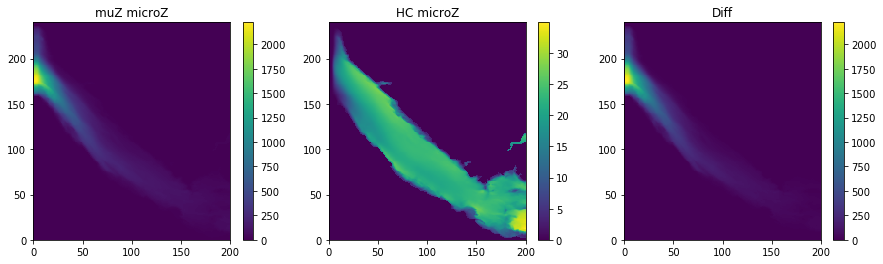

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
m0 = ax[0].pcolormesh(uZmuZInt)
plt.colorbar(m0, ax=ax[0])
ax[0].set_title('muZ microZ')
m1 = ax[1].pcolormesh(uZHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC microZ')
m2 = ax[2].pcolormesh(uZmuZInt - uZHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')

In [22]:
client.close()